<a href="https://colab.research.google.com/github/EldarEyvazov/Optimisation-of-SVM-training/blob/main/SVM_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We start by preparing our datasets, in this project we are going to use 2 datasets:

*   Breast Cancer dataset
*   a4a dataset



# a4a dataset

In [ ]:
import numpy as np
import os
import urllib.request
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_svmlight_file

# Function to download and load the a4a dataset in sparse format
def load_a4a_dataset(file_path="a4a"):
    # Check if the dataset already exists, if not, download it
    if not os.path.exists(file_path):
        print("Downloading a4a dataset...")
        url = "https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/a4a"
        urllib.request.urlretrieve(url, file_path)
        print("a4a dataset downloaded successfully.")

    # Load the dataset from the file in sparse format
    print(f"Loading the {file_path} dataset...")
    X, y = load_svmlight_file(file_path)

    # Do not convert to dense format, keep it sparse
    return X, y

# Load the a4a dataset
X_a4a, y_a4a = load_a4a_dataset()

# Adjust labels: 1 -> 1, 0 -> -1
y_a4a = np.where(y_a4a == 1, 1, -1)

# Split the dataset into training and test sets
X_train_a4a, X_test_a4a, y_train_a4a, y_test_a4a = train_test_split(X_a4a, y_a4a, test_size=0.25, random_state=42)

# Output the shapes of the training and test sets
print(f"Training set shape: X_train={X_train_a4a.shape}, y_train={y_train_a4a.shape}")
print(f"Test set shape: X_test={X_test_a4a.shape}, y_test={y_test_a4a.shape}")


Loading the a4a dataset...
Training set shape: X_train=(3585, 122), y_train=(3585,)
Test set shape: X_test=(1196, 122), y_test=(1196,)


Before starting to modelling we have to check whether we have class imbalance across the datasets or not.

In [ ]:
import numpy as np

def check_class_balance(y):

    # Count occurrences of each class
    unique_classes, class_counts = np.unique(y, return_counts=True)

    # Calculate total samples and class ratios
    total_samples = len(y)
    class_ratios = {cls: count / total_samples for cls, count in zip(unique_classes, class_counts)}

    # Print class information
    print("Class Distribution:")
    for cls, count in zip(unique_classes, class_counts):
        print(f"Class {cls}: {count} samples ({class_ratios[cls]:.2%} of total)")

    # Check if dataset is imbalanced (arbitrarily considering imbalance if one class is <40% of total)
    is_imbalanced = any(ratio < 0.4 for ratio in class_ratios.values())
    if is_imbalanced:
        print("\nThe dataset is imbalanced.")
    else:
        print("\nThe dataset is balanced.")

    return {"class_counts": dict(zip(unique_classes, class_counts)), "class_ratios": class_ratios}

# Check for class imbalance in the a4a dataset
class_info = check_class_balance(y_a4a)


Class Distribution:
Class -1: 3593 samples (75.15% of total)
Class 1: 1188 samples (24.85% of total)

The dataset is imbalanced.


# Breast Cancer dataset

In [ ]:
import urllib.request
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def load_and_prepare_data(url, test_size=0.25, random_state=42):

    # Step 1: Download the file
    file_path = "breast-cancer_scale.txt"
    urllib.request.urlretrieve(url, file_path)

    # Step 2: Load the data using load_svmlight_file
    X, y = load_svmlight_file(file_path)
    X = X.todense()  # Convert sparse matrix to dense format

    # Step 3: Transform labels (2 -> 1, 4 -> -1)
    y[y == 2] = 1
    y[y == 4] = -1

    # Step 4: Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    return X_train, X_test, y_train, y_test

def check_and_normalize(X_train, X_test):
    # Convert np.matrix to np.array
    if isinstance(X_train, np.matrix):
        X_train = np.asarray(X_train)
    if isinstance(X_test, np.matrix):
        X_test = np.asarray(X_test)

    # Step 1: Check for missing values
    missing_train = np.isnan(X_train).sum()
    missing_test = np.isnan(X_test).sum()

    print(f"Missing values in training set: {missing_train}")
    print(f"Missing values in test set: {missing_test}")

    # Step 2: Normalize data to range [-1, 1]
    scaler = MinMaxScaler(feature_range=(-1, 1))
    X_train_normalized = scaler.fit_transform(X_train)
    X_test_normalized = scaler.transform(X_test)

    print("Data has been normalized to range [-1, 1]")

    return X_train_normalized, X_test_normalized

url = "https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/breast-cancer_scale"
X_train, X_test, y_train, y_test = load_and_prepare_data(url)

# Normalize and check for missing values
X_train_normalized, X_test_normalized = check_and_normalize(X_train, X_test)


Missing values in training set: 0
Missing values in test set: 0
Data has been normalized to range [-1, 1]


In [ ]:
check_class_balance(y_train)

Class Distribution:
Class -1.0: 171 samples (33.40% of total)
Class 1.0: 341 samples (66.60% of total)

The dataset is imbalanced.


{'class_counts': {-1.0: 171, 1.0: 341},
 'class_ratios': {-1.0: 0.333984375, 1.0: 0.666015625}}

# Problem formulation

In [ ]:
import numpy as np
import time
from scipy.sparse import hstack, issparse, vstack, diags

class FrankWolfeOptimizer:
    def __init__(self,
                 C=0.01,
                 initial_solution=None,
                 epsilon=1e-5,
                 max_iterations=1e5):
        self.C = C
        self.initial_solution = initial_solution
        self.epsilon = epsilon
        self.max_iterations = max_iterations
        self.constraint_matrix = None
        self.objective_value = None
        self.history = None

    def _initialize_solution(self, dimension):
        x_0 = np.zeros((dimension, 1))
        x_0[0] = 1.0
        return x_0

    def _add_bias_to_features(self, features):
        num_samples = features.shape[0]

        # Check if the matrix is sparse
        if issparse(features):
            # Use hstack for sparse matrix concatenation
            bias_column = np.ones((num_samples, 1))
            bias_column_sparse = diags(bias_column[:, 0], 0)
            features_with_bias = hstack([features, bias_column_sparse])
        else:
            # Use np.concatenate for dense matrices
            features_with_bias = np.concatenate((features, np.ones((num_samples, 1))), axis=1)

        return features_with_bias

    def _build_constraint_matrix(self, features, labels):
        features_with_bias = self._add_bias_to_features(features)

        # Ensuring that labels are column vectors
        labels = labels.reshape(-1, 1)

        # Apply the labels to the features by element-wise multiplication
        if issparse(features_with_bias):
            weighted_features = features_with_bias.multiply(labels)
        else:
            weighted_features = features_with_bias * labels

        # Regularization term
        identity_matrix = (1 / np.sqrt(self.C)) * np.eye(features_with_bias.shape[0])

        # Concatenate weighted features and identity matrix (constraint matrix)
        if issparse(weighted_features):
            constraint_matrix = vstack([weighted_features.T, identity_matrix])
        else:
            constraint_matrix = np.concatenate((weighted_features.T, identity_matrix), axis=0)

        return constraint_matrix

    def _objective(self, solution=None):
        if solution is None:
            solution = self.initial_solution
        return (np.linalg.norm(self.constraint_matrix @ solution, ord=2) ** 2).item()

    def _compute_gradient(self):
        A_transpose_dot_x = self.constraint_matrix @ self.initial_solution
        gradient = 2 * (self.constraint_matrix.T @ A_transpose_dot_x)
        return gradient

    def _linear_minimization_oracle(self, gradient):
        min_index = gradient.argmin()
        s = np.zeros_like(gradient)
        s[min_index] = 1
        return s

    def _frank_wolfe_step(self):
        gradient = self._compute_gradient()
        linear_minimizer = self._linear_minimization_oracle(gradient)
        fw_direction = linear_minimizer - self.initial_solution  # This is s_k - x_k (FW direction)
        dual_gap = - np.dot(gradient.T, fw_direction).item()
        return gradient, linear_minimizer, fw_direction, dual_gap

    def _armijo_line_search(self, fw_direction, dual_gap, max_step_size):
        previous_solution = self.initial_solution
        previous_objective_value = self.objective_value
        alpha, beta = 0.1, 0.8

        step_size = max_step_size
        new_solution = previous_solution + step_size * fw_direction
        new_objective_value = self._objective(new_solution)
        iterations = 0

        while new_objective_value > previous_objective_value + alpha * step_size * (-dual_gap):
            iterations += 1
            step_size *= beta
            new_solution = previous_solution + step_size * fw_direction
            new_objective_value = self._objective(new_solution)
            if iterations >= 1000:
                break

        return new_solution, new_objective_value

    def _calculate_weights_and_bias(self, feature_count):
        weight_bias_vector = self.constraint_matrix @ self.initial_solution
        self.weights = weight_bias_vector[:feature_count]
        self.bias = weight_bias_vector[feature_count: feature_count + 1]

    def predict(self, features):
        if not hasattr(self, 'weights') or not hasattr(self, 'bias'):
            raise ValueError("Model weights and bias have not been calculated. Call 'fit' to train the model first.")
        if not issparse(features):
            features = np.array(features)

        predictions = features @ self.weights + self.bias
        return np.where(predictions > 0, 1, -1)

    def compute_accuracy(self, labels, predictions=None, features=None):
        if features is None and predictions is None:
            raise ValueError("You must provide either features for prediction or precomputed predictions.")
        elif features is not None and predictions is not None:
            raise ValueError("Provide only one: either features or precomputed predictions.")
        elif features is not None:
            predictions = self.predict(features)

        if labels.ndim == 1 or predictions.ndim == 1:
            labels = labels.reshape(-1, 1)
            predictions = predictions.reshape(-1, 1)

        if labels.shape != predictions.shape:
            raise ValueError("Shape mismatch between true labels and predictions.")
        return np.sum(predictions == labels) / len(labels)




    def fit(self, features, labels, step_size_strategy="armijo"):
        """
        Fit the model using Frank-Wolfe optimization with a choice of step size strategy.
        - step_size_strategy: "armijo" or "diminishing" we choose our step size strategy to train the model.
        """
        self.constraint_matrix = self._build_constraint_matrix(features, labels)
        solution_dim = self.constraint_matrix.shape[1]
        feature_count = features.shape[1]

        if self.initial_solution is None:
            self.initial_solution = self._initialize_solution(solution_dim)

        self.objective_value = self._objective()
        max_step_size = 1

        self.history = {"iteration": [0], "cpu_time": [0], "objective_value": [self.objective_value], "dual_gap": []}
        start_time = time.time()

        for iteration in range(int(self.max_iterations)):
            grad, s, fw_direction, dual_gap = self._frank_wolfe_step()
            self.history["dual_gap"].append(dual_gap)

            if dual_gap <= self.epsilon:
                print(f"Convergence achieved: dual gap <= epsilon at iteration {iteration + 1}")
                break

            if step_size_strategy == "armijo":
                # Use Armijo line search
                self.initial_solution, self.objective_value = self._armijo_line_search(fw_direction, dual_gap, max_step_size)
            elif step_size_strategy == "diminishing":
                # Use diminishing step size: gamma_k = 2 / (k + 2)
                step_size = 2 / (iteration + 2)
                self.initial_solution = self.initial_solution + step_size * fw_direction  # Correct update using diminishing step size
                self.objective_value = self._objective(self.initial_solution)
            else:
                raise ValueError(f"Unknown step size strategy: {step_size_strategy}")

            elapsed_time = time.time()
            self.history["iteration"].append(iteration + 1)
            self.history["objective_value"].append(self.objective_value)
            self.history["cpu_time"].append(elapsed_time - start_time)

        self._calculate_weights_and_bias(feature_count)


In [ ]:
# Training with diminishing step size strategy on "Breast Cancer Dataset"
fw_model_bc_diminishing = FrankWolfeOptimizer(C=1, epsilon=1e-6, max_iterations=3000)
fw_model_bc_diminishing.fit(X_train_normalized, y_train, step_size_strategy="diminishing")


In [ ]:
# Make predictions on the test set (Diminishing step size strategy on Breast Cancer dataset)
y_pred_bc_dim = fw_model_bc_diminishing.predict(X_test_normalized)

# Calculate accuracy
accuracy_fw_bc_dim = fw_model_bc_diminishing.compute_accuracy(y_test, predictions=y_pred_bc_dim)
print(f"Test Accuracy of Frank-Wolfe algorithm with diminishing step size strategy on Breast Cancer dataset: {accuracy_fw_bc_dim  * 100:.2f}%")

Test Accuracy of Frank-Wolfe algorithm with diminishing step size strategy on Breast Cancer dataset: 94.74%


In [ ]:
#Training model on Breast Cancer dataset with armijo line search

fw_model_bc_armijo =FrankWolfeOptimizer(C=1, epsilon=1e-6, max_iterations=2000)
fw_model_bc_armijo.fit(X_train_normalized, y_train, step_size_strategy="armijo")




In [ ]:
# Make predictions on the test set (Armijo step size strategy on Breast Cancer dataset)
y_pred_bc_armijo = fw_model_bc_armijo.predict(X_test_normalized)

# Calculate accuracy
accuracy_fw_bc_armijo = fw_model_bc_armijo.compute_accuracy(y_test, predictions=y_pred_bc_armijo)
print(f"Test Accuracy of Frank-Wolfe algorithm with armijo line search strategy on Breast Cancer dataset: {accuracy_fw_bc_armijo  * 100:.2f}%")

Test Accuracy of Frank-Wolfe algorithm with armijo line search strategy on Breast Cancer dataset: 95.32%


Now checking model performance on a4a Dataset with both step_size strategies.

*   Diminishing Step Size
*   Armijo Line Search



In [ ]:
#Training on a4a dataset with diminishing step size strategy
fw_model_a4a_diminishing = FrankWolfeOptimizer(C=0.1, epsilon=1e-6, max_iterations=5000)
fw_model_a4a_diminishing.fit(X_train_a4a, y_train_a4a, step_size_strategy="diminishing")


In [ ]:
# Make predictions on the test set
y_pred_a4a_dim = fw_model_a4a_diminishing.predict(X_test_a4a)

# Calculate accuracy by passing predictions directly
accuracy_fw_a4a_dim = fw_model_a4a_diminishing.compute_accuracy(y_test_a4a, y_pred_a4a_dim)
print(f"Test Accuracy of Frank-Wolfe algorithm with diminishing step size  on a4a dataset: {accuracy_fw_a4a_dim * 100:.2f}%")


Test Accuracy of Frank-Wolfe algorithm with diminishing step size  on a4a dataset: 82.11%


In [ ]:
#Training on a4a dataset with armijo line search
fw_model_a4a_armijo = FrankWolfeOptimizer(C=0.1, epsilon=1e-6, max_iterations=5000)
fw_model_a4a_armijo.fit(X_train_a4a, y_train_a4a, step_size_strategy="armijo")


In [ ]:
# Make predictions on the test set (a4a dataset) step_size strategy: "armijo line search"
y_pred_a4a_armijo = fw_model_a4a_armijo.predict(X_test_a4a)

# Calculate accuracy by passing predictions directly
accuracy_fw_a4a_armijo = fw_model_a4a_armijo.compute_accuracy(y_test_a4a, y_pred_a4a_armijo)
print(f"Test Accuracy of Frank-Wolfe algorithm on a4a dataset with armijo line search: {accuracy_fw_a4a_armijo * 100:.2f}%")


Test Accuracy of Frank-Wolfe algorithm on a4a dataset with armijo line search: 85.45%


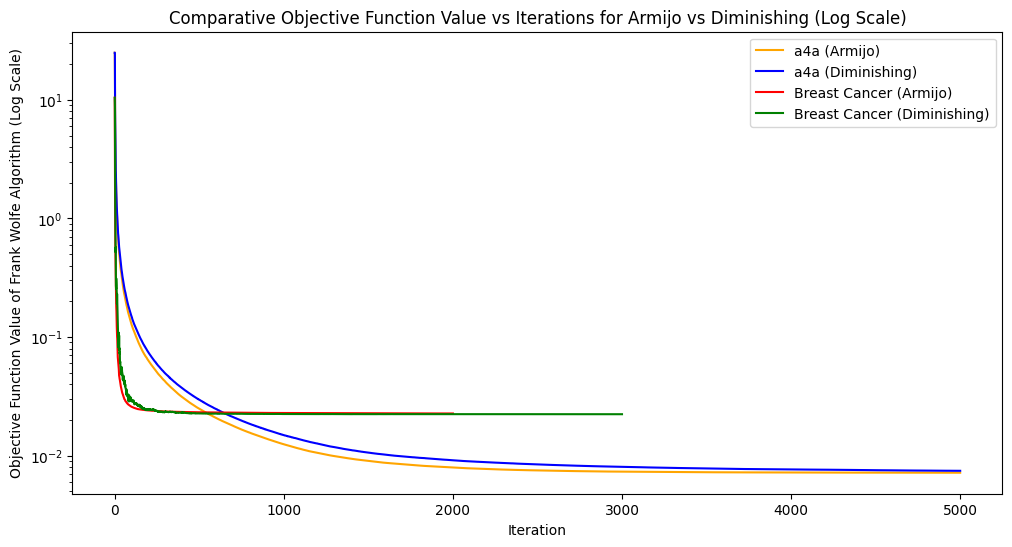

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_comparative_objective_function_multi(history_a4a_armijo, history_a4a_diminishing, history_bc_armijo, history_bc_diminishing):
    """
    Plots comparative objective function values for four histories:
    1. a4a dataset with Armijo line search
    2. a4a dataset with Diminishing step size
    3. Breast Cancer dataset with Armijo line search
    4. Breast Cancer dataset with Diminishing step size
    """
    # Extract iterations and objective values for each model
    iterations_a4a_armijo = history_a4a_armijo["iteration"]
    of_values_a4a_armijo = history_a4a_armijo["objective_value"]

    iterations_a4a_diminishing = history_a4a_diminishing["iteration"]
    of_values_a4a_diminishing = history_a4a_diminishing["objective_value"]

    iterations_bc_armijo = history_bc_armijo["iteration"]
    of_values_bc_armijo = history_bc_armijo["objective_value"]

    iterations_bc_diminishing = history_bc_diminishing["iteration"]
    of_values_bc_diminishing = history_bc_diminishing["objective_value"]

    # Create a new figure
    plt.figure(figsize=(12, 6))

    # Plot objective function values for each model
    plt.plot(iterations_a4a_armijo, of_values_a4a_armijo, linestyle='-', color='orange', label='a4a (Armijo)')
    plt.plot(iterations_a4a_diminishing, of_values_a4a_diminishing, linestyle='-', color='b', label='a4a (Diminishing)')
    plt.plot(iterations_bc_armijo, of_values_bc_armijo, linestyle='-', color='r', label='Breast Cancer (Armijo)')
    plt.plot(iterations_bc_diminishing, of_values_bc_diminishing, linestyle='-', color='green', label='Breast Cancer (Diminishing)')

    # Set y-axis to logarithmic scale
    plt.yscale('log')



    # Add labels, title, and legend
    plt.xlabel('Iteration')
    plt.ylabel('Objective Function Value of Frank Wolfe Algorithm (Log Scale)')
    plt.title('Comparative Objective Function Value vs Iterations for Armijo vs Diminishing (Log Scale)')
    plt.legend()

    # Show the plot
    plt.show()

# Now, after defining the function, you can call it using the history from your models:
# Replace the placeholders with your actual model history data
plot_comparative_objective_function_multi(
    fw_model_a4a_armijo.history,
    fw_model_a4a_diminishing.history,
    fw_model_bc_armijo.history,
    fw_model_bc_diminishing.history
)


This plot compares the objective function value convergence for a4a and breast cancer datasets using the Armijo line search and diminishing step size strategies. For the a4a dataset, diminishing step size shows a faster initial reduction in the objective function, giving it an early advantage. However, Armijo eventually catches up and slightly overtakes it in later iterations. For the breast cancer dataset, both strategies show very similar performance, with diminishing step size matching Armijo quickly. Overall, Armijo performs better in the long run, especially for larger datasets like a4a, while diminishing step size shows faster early-stage convergence but becomes comparable over time.

In [ ]:
# Extract final objective function values
final_of_a4a_armijo_fw = fw_model_a4a_armijo.history["objective_value"][-1]
final_of_a4a_diminishing_fw = fw_model_a4a_diminishing.history["objective_value"][-1]
final_of_bc_armijo_fw = fw_model_bc_armijo.history["objective_value"][-1]
final_of_bc_diminishing_fw = fw_model_bc_diminishing.history["objective_value"][-1]

# Print the final objective function values
print("-----------------------Frank Wolfe Model Objective Function Value-----------------------")
print(f"Final Objective Function Value (a4a - Armijo): {final_of_a4a_armijo_fw:.6f}")
print(f"Final Objective Function Value (a4a - Diminishing): {final_of_a4a_diminishing_fw:.6f}")
print(f"Final Objective Function Value (Breast Cancer - Armijo): {final_of_bc_armijo_fw:.6f}")
print(f"Final Objective Function Value (Breast Cancer - Diminishing): {final_of_bc_diminishing_fw:.6f}")


-----------------------Frank Wolfe Model Objective Function Value-----------------------
Final Objective Function Value (a4a - Armijo): 0.007168
Final Objective Function Value (a4a - Diminishing): 0.007442
Final Objective Function Value (Breast Cancer - Armijo): 0.022653
Final Objective Function Value (Breast Cancer - Diminishing): 0.022329


In [ ]:
#lets plot final cpu time of model on each dataset with different step size strategy

cpu_a4a_armijo_fw = fw_model_a4a_armijo.history["cpu_time"][-1]
cpu_a4a_diminishing_fw = fw_model_a4a_diminishing.history["cpu_time"][-1]
cpu_bc_armijo_fw = fw_model_bc_armijo.history["cpu_time"][-1]
cpu_bc_diminishing_fw = fw_model_bc_diminishing.history["cpu_time"][-1]

#printing the results
print("-----------------------Frank Wolfe Model CPU Time-----------------------")
print(f"Final CPU Time (a4a - Armijo): {cpu_a4a_armijo_fw:.6f} seconds")
print(f"Final CPU Time (a4a - Diminishing): {cpu_a4a_diminishing_fw:.6f} seconds")
print(f"Final CPU Time (Breast Cancer - Armijo): {cpu_bc_armijo_fw:.6f} seconds")
print(f"Final CPU Time (Breast Cancer - Diminishing): {cpu_bc_diminishing_fw:.6f} seconds")

-----------------------Frank Wolfe Model CPU Time-----------------------
Final CPU Time (a4a - Armijo): 54.822754 seconds
Final CPU Time (a4a - Diminishing): 3.835219 seconds
Final CPU Time (Breast Cancer - Armijo): 32.446225 seconds
Final CPU Time (Breast Cancer - Diminishing): 5.588241 seconds


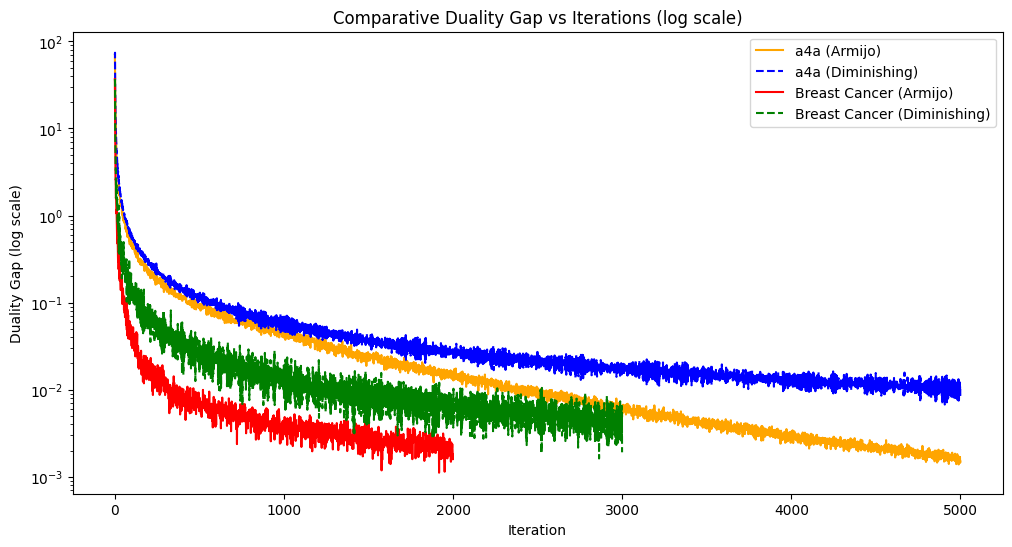

In [ ]:
import matplotlib.pyplot as plt

def plot_comparative_duality_gap_multi(history_a4a_armijo, history_a4a_diminishing, history_bc_armijo, history_bc_diminishing):

    # Helper function to ensure matching lengths
    def align_lengths(iterations, duality_gaps):
        min_length = min(len(iterations), len(duality_gaps))
        return iterations[:min_length], duality_gaps[:min_length]

    # Extract and align iterations and duality gaps for each model
    iterations_a4a_armijo, duality_gaps_a4a_armijo = align_lengths(
        history_a4a_armijo["iteration"], history_a4a_armijo["dual_gap"])

    iterations_a4a_diminishing, duality_gaps_a4a_diminishing = align_lengths(
        history_a4a_diminishing["iteration"], history_a4a_diminishing["dual_gap"])

    iterations_bc_armijo, duality_gaps_bc_armijo = align_lengths(
        history_bc_armijo["iteration"], history_bc_armijo["dual_gap"])

    iterations_bc_diminishing, duality_gaps_bc_diminishing = align_lengths(
        history_bc_diminishing["iteration"], history_bc_diminishing["dual_gap"])

    # Create a new figure
    plt.figure(figsize=(12, 6))

    # Plot the duality gap values for all models on a log scale
    plt.semilogy(iterations_a4a_armijo, duality_gaps_a4a_armijo, linestyle='-', color='orange', label='a4a (Armijo)')
    plt.semilogy(iterations_a4a_diminishing, duality_gaps_a4a_diminishing, linestyle='--', color='b', label='a4a (Diminishing)')
    plt.semilogy(iterations_bc_armijo, duality_gaps_bc_armijo, linestyle='-', color='r', label='Breast Cancer (Armijo)')
    plt.semilogy(iterations_bc_diminishing, duality_gaps_bc_diminishing, linestyle='--', color='g', label='Breast Cancer (Diminishing)')

    # Add labels, title, and legend
    plt.xlabel('Iteration')
    plt.ylabel('Duality Gap (log scale)')
    plt.title('Comparative Duality Gap vs Iterations (log scale)')
    plt.legend()

    # Show the plot
    plt.show()

plot_comparative_duality_gap_multi(
    fw_model_a4a_armijo.history,
    fw_model_a4a_diminishing.history,
    fw_model_bc_armijo.history,
    fw_model_bc_diminishing.history
)


This plot shows a comparison of the duality gap convergence for a4a and breast cancer datasets using Armijo line search and diminishing step size strategies. For the a4a dataset, both strategies converge similarly after around 500 iterations, with Armijo having a slight advantage early on. In contrast, for the breast cancer dataset, Armijo significantly outperforms diminishing step size, offering faster and smoother convergence. While diminishing step size is more efficient computationally, it introduces more noise, especially for smaller datasets like breast cancer.

In [ ]:
# Extract final duality gap values
final_duality_gap_a4a_armijo = fw_model_a4a_armijo.history["dual_gap"][-1]
final_duality_gap_a4a_diminishing = fw_model_a4a_diminishing.history["dual_gap"][-1]
final_duality_gap_bc_armijo = fw_model_bc_armijo.history["dual_gap"][-1]
final_duality_gap_bc_diminishing = fw_model_bc_diminishing.history["dual_gap"][-1]

# Print the final duality gap values
print(f"Final Duality Gap in Log scale (a4a - Armijo): {final_duality_gap_a4a_armijo:.6f}")
print(f"Final Duality Gap in Log scale (a4a - Diminishing): {final_duality_gap_a4a_diminishing:.6f}")
print(f"Final Duality Gap in Log scale (Breast Cancer - Armijo): {final_duality_gap_bc_armijo:.6f}")
print(f"Final Duality Gap in Log scale (Breast Cancer - Diminishing): {final_duality_gap_bc_diminishing:.6f}")


Final Duality Gap in Log scale (a4a - Armijo): 0.001502
Final Duality Gap in Log scale (a4a - Diminishing): 0.008499
Final Duality Gap in Log scale (Breast Cancer - Armijo): 0.001805
Final Duality Gap in Log scale (Breast Cancer - Diminishing): 0.001911


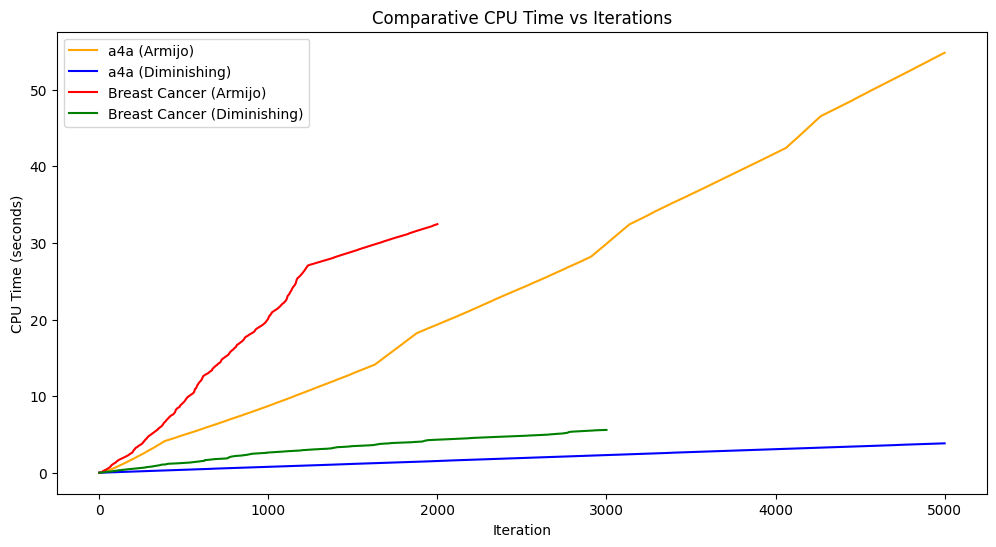

In [ ]:
import matplotlib.pyplot as plt

def plot_comparative_cpu_times_multi(history_a4a_armijo, history_a4a_diminishing, history_bc_armijo, history_bc_diminishing):
    """
    Plots comparative CPU times for four histories:
    1. a4a dataset with Armijo line search
    2. a4a dataset with Diminishing step size
    3. Breast Cancer dataset with Armijo line search
    4. Breast Cancer dataset with Diminishing step size
    """
    # Extract iterations and CPU times for each model
    iterations_a4a_armijo_fw = history_a4a_armijo["iteration"]
    cpu_times_a4a_armijo_fw = history_a4a_armijo["cpu_time"]

    iterations_a4a_diminishing_fw = history_a4a_diminishing["iteration"]
    cpu_times_a4a_diminishing_fw = history_a4a_diminishing["cpu_time"]

    iterations_bc_armijo_fw = history_bc_armijo["iteration"]
    cpu_times_bc_armijo_fw = history_bc_armijo["cpu_time"]

    iterations_bc_diminishing_fw = history_bc_diminishing["iteration"]
    cpu_times_bc_diminishing_fw = history_bc_diminishing["cpu_time"]

    # Create a new figure
    plt.figure(figsize=(12, 6))

    # Plot CPU times for each model
    plt.plot(iterations_a4a_armijo_fw, cpu_times_a4a_armijo_fw, linestyle='-', color='orange', label='a4a (Armijo)')
    plt.plot(iterations_a4a_diminishing_fw, cpu_times_a4a_diminishing_fw, linestyle='-', color='b', label='a4a (Diminishing)')
    plt.plot(iterations_bc_armijo_fw, cpu_times_bc_armijo_fw, linestyle='-', color='r', label='Breast Cancer (Armijo)')
    plt.plot(iterations_bc_diminishing_fw, cpu_times_bc_diminishing_fw, linestyle='-', color='g', label='Breast Cancer (Diminishing)')

    # Add labels, title, and legend
    plt.xlabel('Iteration')
    plt.ylabel('CPU Time (seconds)')
    plt.title('Comparative CPU Time vs Iterations')
    plt.legend()

    # Show the plot
    plt.show()

# Now, after defining the function, you can call it using the history from your models:
# Replace the placeholders with your actual model history data
plot_comparative_cpu_times_multi(
    fw_model_a4a_armijo.history,
    fw_model_a4a_diminishing.history,
    fw_model_bc_armijo.history,
    fw_model_bc_diminishing.history
)


Armijo line search shows better convergence in both objective function values and duality gap reduction, but at the cost of higher CPU time, especially for larger datasets like a4a. Diminishing step size is much faster and more efficient but with a slight trade-off in convergence accuracy. Overall, diminishing step size strategy might offer computational efficiency, while Armijo line search strategy  is better for more precise convergence, particularly in larger-scale problems.

In [ ]:
import prettytable

def print_fw_training_summary():
    # Creating a pretty table for FW
    table = prettytable.PrettyTable()
    table.field_names = [
        "Model Name", "Dataset", "Line Search",
        "Final Objective Value", "Dual Gap",
        "Accuracy (%)", "Total CPU Time (s)"
    ]

    # Add rows with accuracy values
    table.add_row([
        "FW", "A4A", "Armijo",
        round(fw_model_a4a_armijo.history["objective_value"][-1], 4),
        "{:.4e}".format(fw_model_a4a_armijo.history["dual_gap"][-1]),
        f"{accuracy_fw_a4a_armijo * 100:.2f}",
        round(fw_model_a4a_armijo.history["cpu_time"][-1], 2)
    ])
    table.add_row([
        "FW", "A4A", "Diminishing",
        round(fw_model_a4a_diminishing.history["objective_value"][-1], 4),
        "{:.4e}".format(fw_model_a4a_diminishing.history["dual_gap"][-1]),
        f"{accuracy_fw_a4a_dim * 100:.2f}",
        round(fw_model_a4a_diminishing.history["cpu_time"][-1], 2)
    ])
    table.add_row([
        "FW", "Breast Cancer", "Armijo",
        round(fw_model_bc_armijo.history["objective_value"][-1], 4),
        "{:.4e}".format(fw_model_bc_armijo.history["dual_gap"][-1]),
        f"{accuracy_fw_bc_armijo * 100:.2f}",
        round(fw_model_bc_armijo.history["cpu_time"][-1], 2)
    ])
    table.add_row([
        "FW", "Breast Cancer", "Diminishing",
        round(fw_model_bc_diminishing.history["objective_value"][-1], 4),
        "{:.4e}".format(fw_model_bc_diminishing.history["dual_gap"][-1]),
        f"{accuracy_fw_bc_dim * 100:.2f}",
        round(fw_model_bc_diminishing.history["cpu_time"][-1], 2)
    ])

    # Print the title first
    print("----------------------------------------Frank-Wolfe Results----------------------------------------")
    print(table)

# Print Frank-Wolfe training summary
print_fw_training_summary()




----------------------------------------Frank-Wolfe Results----------------------------------------
+------------+---------------+-------------+-----------------------+------------+--------------+--------------------+
| Model Name |    Dataset    | Line Search | Final Objective Value |  Dual Gap  | Accuracy (%) | Total CPU Time (s) |
+------------+---------------+-------------+-----------------------+------------+--------------+--------------------+
|     FW     |      A4A      |    Armijo   |         0.0072        | 1.5017e-03 |    85.45     |       54.82        |
|     FW     |      A4A      | Diminishing |         0.0074        | 8.4990e-03 |    82.11     |        3.84        |
|     FW     | Breast Cancer |    Armijo   |         0.0227        | 1.8052e-03 |    95.32     |       32.45        |
|     FW     | Breast Cancer | Diminishing |         0.0223        | 1.9114e-03 |    94.74     |        5.59        |
+------------+---------------+-------------+-----------------------+------

# ---- Projected Gradient Method----


In [ ]:
import numpy as np
from scipy.sparse import issparse, diags, hstack, vstack
from scipy.spatial import distance
import time


class PGD:
    def __init__(self, X_train, y_train, C=0.1, epsilon=1e-6, s=0.1, max_iterations=1000, step_method=None):
        self.X_train = X_train
        self.y_train = y_train
        self.C = C
        self.epsilon = epsilon
        self.s = s
        self.max_iterations = max_iterations
        self.step_method = step_method
        self.A = self.build_constraint_matrix()

        # Initialize history attribute
        self.history = None

    # Initialize the vector x (1D array)
    def init_x(self, n):
        x_0 = np.zeros(n)  # Use 1D vector
        x_0[0] = 1.0
        return x_0

    # Adding a bias term to features
    def add_bias_to_features(self, features):
        num_samples = features.shape[0]

        if issparse(features):
            bias_column = np.ones((num_samples, 1))
            bias_column_sparse = diags(bias_column[:, 0], 0)
            features_with_bias = hstack([features, bias_column_sparse])
        else:
            features_with_bias = np.concatenate((features, np.ones((num_samples, 1))), axis=1)

        return features_with_bias

    # Building the constraint matrix
    def build_constraint_matrix(self):
        features_with_bias = self.add_bias_to_features(self.X_train)
        labels = self.y_train.reshape(-1, 1)

        if issparse(features_with_bias):
            weighted_features = features_with_bias.multiply(labels)
        else:
            weighted_features = features_with_bias * labels

        identity_matrix = (1 / np.sqrt(self.C)) * np.eye(features_with_bias.shape[0])

        if issparse(weighted_features):
            constraint_matrix = vstack([weighted_features.T, identity_matrix])
        else:
            constraint_matrix = np.concatenate((weighted_features.T, identity_matrix), axis=0)

        return constraint_matrix

    # Objective function
    def objective_function(self, A, x):
        return np.linalg.norm(A @ x, ord=2) ** 2

    # Gradient computation
    def gradient(self, A, x):
        A_transpose_dot_x = A @ x
        return 2 * (A.T @ A_transpose_dot_x)

    # Calculate weights and bias
    def calculate_weights_and_bias(self, A, x, feature_count):
        weight_bias_vector = A @ x
        weights = weight_bias_vector[:feature_count]
        bias = weight_bias_vector[feature_count: feature_count + 1]
        return weights, bias

    # Prediction function
    def predict(self, features, weights, bias):
        predictions = features @ weights + bias
        return np.where(predictions > 0, 1, -1)

    # Accuracy computation
    def compute_accuracy(self, labels, predictions=None, features=None, weights=None, bias=None):
        if features is not None:
            predictions = self.predict(features, weights, bias)

        labels = labels.reshape(-1, 1)
        predictions = predictions.reshape(-1, 1)

        return np.sum(predictions == labels) / len(labels)

    # Armijo line search
    def armijo_line_search(self, A, x, dk, initial_gamma=1, beta=0.8, sigma=0.1):
        gamma = initial_gamma
        while True:
            lhs = self.objective_function(A, x + gamma * dk)
            rhs = self.objective_function(A, x) + sigma * gamma * np.dot(self.gradient(A, x).T, dk)
            if lhs <= rhs:
                break
            gamma *= beta
        return gamma

    # Project onto the unit simplex
    def project_onto_unit_simplex(self, y):
        n = y.shape[0]
        a = 1  # 'a' represents the target sum of the projected vector

        u = np.sort(y)[::-1]
        cum_sum = np.cumsum(u) - a
        indices = np.arange(1, n + 1)
        k = np.max(np.where((cum_sum) / indices < u)[0])

        tau = (np.sum(u[:k + 1]) - a) / (k + 1)
        return np.maximum(y - tau, 0)

    def projected_gradient_method(self):
        features = self.X_train.shape[1]
        n = self.A.shape[1]

        x = self.init_x(n)

        # Initialize history
        self.history = {
            "iteration": [0],
            "cpu_time": [0],
            "objective_value": [self.objective_function(self.A, x)],
            "gradient_mapping": []
        }

        start_time = time.time()  # Start timing for the entire training process

        for k in range(1, self.max_iterations + 1):
            x_hat = self.project_onto_unit_simplex(x - self.s * self.gradient(self.A, x))
            g = distance.euclidean(x, x_hat)

            # Compute objective value and update history
            objective_value = self.objective_function(self.A, x)
            current_time = time.time() - start_time

            self.history["iteration"].append(k)
            self.history["cpu_time"].append(current_time)
            self.history["objective_value"].append(objective_value)
            self.history["gradient_mapping"].append(g)

            # Print progress every 10% of max_iterations or if stopping criteria is met
            if k % (self.max_iterations // 10) == 0 or g <= self.epsilon:
                print(f'Iter {k:03d}: f(x) = {objective_value:.2e}, ||g|| = {g:.2e}, Time Elapsed: {current_time:.2f}s')

            if g <= self.epsilon: #our stopping condition
                print(f"Stopping criteria reached at iteration {k}")
                break

            dk = x_hat - x

            if self.step_method == "armijo":
                gamma = self.armijo_line_search(self.A, x, dk, initial_gamma=1, beta=0.8, sigma=0.1)
            else:
                raise ValueError("Invalid step_method.")

            x = x + gamma * dk

        end_time = time.time()  # End timing for the training process
        total_training_time = end_time - start_time  # Calculate total elapsed time

        w, b = self.calculate_weights_and_bias(self.A, x, features)
        return x, w, b, self.history, total_training_time

    def train_and_evaluate(self, X_test, y_test):
        x_opt, w, b, history, total_training_time = self.projected_gradient_method()

        # Test set evaluation
        y_pred_test = self.predict(X_test, w, b)
        test_accuracy = self.compute_accuracy(y_test, y_pred_test)

        print(f"Test set accuracy: {test_accuracy * 100:.2f}%")
        print(f"Total training time: {total_training_time:.2f} seconds")

        # Include self.history in the return
        return test_accuracy, history, total_training_time


In [ ]:
bc_armijo = PGD(X_train_normalized, y_train, step_method="armijo", C=0.3, epsilon=1e-6, s=0.1, max_iterations=2000)
test_accuracy_bc, history_bc_armijo, total_training_time_bc = bc_armijo.train_and_evaluate(X_test_normalized, y_test)

Iter 200: f(x) = 7.02e-02, ||g|| = 1.46e-02, Time Elapsed: 3.48s
Iter 400: f(x) = 6.97e-02, ||g|| = 2.06e-03, Time Elapsed: 6.16s
Iter 600: f(x) = 6.97e-02, ||g|| = 2.10e-04, Time Elapsed: 7.82s
Iter 800: f(x) = 6.97e-02, ||g|| = 1.72e-05, Time Elapsed: 9.64s
Iter 1000: f(x) = 6.97e-02, ||g|| = 2.16e-06, Time Elapsed: 11.38s
Iter 1067: f(x) = 6.97e-02, ||g|| = 9.69e-07, Time Elapsed: 11.89s
Stopping criteria reached at iteration 1067
Test set accuracy: 94.74%
Total training time: 11.89 seconds


In [ ]:
a4a_armijo = PGD(X_train_a4a, y_train_a4a, step_method="armijo", C=0.4, epsilon=1e-6, s=0.1, max_iterations=5000)
test_accuracy_a4a, history_a4a_armijo, total_training_time_a4a = a4a_armijo.train_and_evaluate(X_test_a4a, y_test_a4a)


Iter 500: f(x) = 3.76e-03, ||g|| = 2.90e-02, Time Elapsed: 11.96s
Iter 1000: f(x) = 2.95e-03, ||g|| = 2.30e-02, Time Elapsed: 25.40s
Iter 1500: f(x) = 2.66e-03, ||g|| = 1.58e-02, Time Elapsed: 48.25s
Iter 2000: f(x) = 2.52e-03, ||g|| = 1.46e-02, Time Elapsed: 62.28s
Iter 2500: f(x) = 2.44e-03, ||g|| = 7.82e-03, Time Elapsed: 76.34s
Iter 3000: f(x) = 2.39e-03, ||g|| = 7.98e-03, Time Elapsed: 90.45s
Iter 3500: f(x) = 2.36e-03, ||g|| = 5.32e-03, Time Elapsed: 104.58s
Iter 4000: f(x) = 2.35e-03, ||g|| = 3.87e-03, Time Elapsed: 119.52s
Iter 4500: f(x) = 2.33e-03, ||g|| = 3.65e-03, Time Elapsed: 135.24s
Iter 5000: f(x) = 2.33e-03, ||g|| = 3.21e-03, Time Elapsed: 149.48s
Test set accuracy: 83.36%
Total training time: 149.50 seconds


In [ ]:
import matplotlib.pyplot as plt

def plot_objective_function(histories, labels, title="Objective Function vs Iterations"):

    if len(histories) != len(labels):
        raise ValueError("The number of histories must match the number of labels.")

    plt.figure(figsize=(12, 6))

    for history, label in zip(histories, labels):
        # Check if the necessary keys exist
        if "iteration" not in history or "objective_value" not in history:
            print(f"Skipping history for {label} due to missing keys.")
            continue

        iterations = history["iteration"]
        objective_values = history["objective_value"]

        # Check if lengths match, and trim the arrays to match the smaller length
        min_length = min(len(iterations), len(objective_values))
        iterations = iterations[:min_length]
        objective_values = objective_values[:min_length]

        # Plot the objective function
        plt.plot(iterations, objective_values, label=f'{label} - Objective Function value', marker='o')

        # Calculate and annotate the final objective value
        final_objective = objective_values[-1]  # The last value of the objective function
        plt.annotate(f"{final_objective:.2e}",
                     xy=(iterations[-1], final_objective),
                     xytext=(iterations[-1] + 50, final_objective * 1.1),
                     arrowprops=dict(arrowstyle="->", color="black"),
                     fontsize=10, color="red")

    plt.xlabel("Iterations")
    plt.ylabel("Objective Function Value (log scale)")
    plt.title(title)
    plt.legend()

    # Set the y-axis to log scale
    plt.yscale('log')

    # Show the plot
    plt.show()


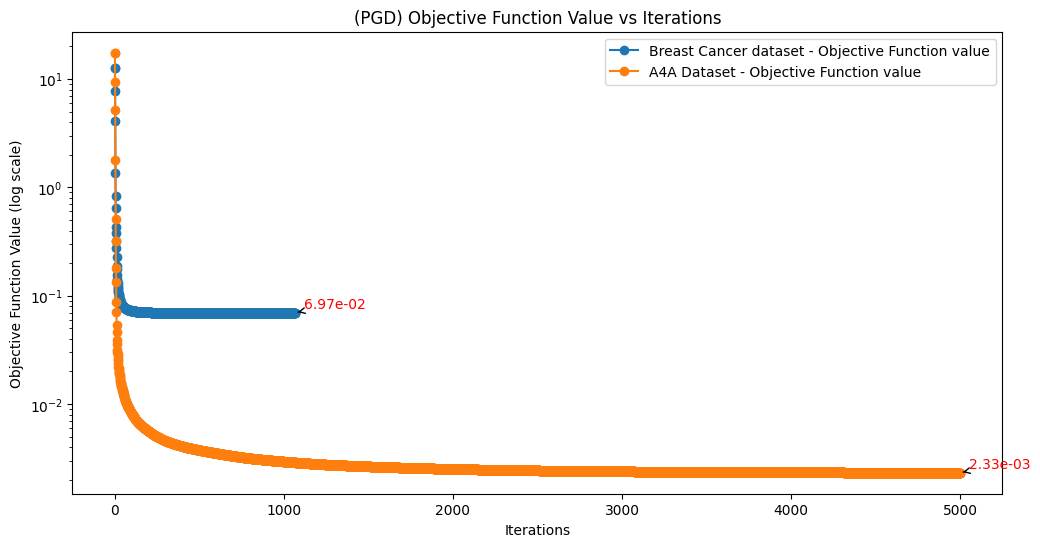

In [ ]:
plot_objective_function(
    histories=[history_bc_armijo, history_a4a_armijo],
    labels=["Breast Cancer dataset", "A4A Dataset"],
    title="(PGD) Objective Function Value vs Iterations"
)


In [ ]:
def plot_cpu_time(histories, labels, title="Cumulative CPU Time vs Iterations"):

    if len(histories) != len(labels):
        raise ValueError("The number of histories must match the number of labels.")

    plt.figure(figsize=(12, 6))

    for history, label in zip(histories, labels):
        # Check if the necessary keys exist
        if "iteration" not in history or "cpu_time" not in history:
            print(f"Skipping history for {label} due to missing keys.")
            continue

        iterations = history["iteration"]
        cpu_times = history["cpu_time"]

        # Plot the cumulative CPU time
        plt.plot(iterations, cpu_times, label=label, marker='o')

        # Calculate and annotate the total training time
        total_time = cpu_times[-1]  # The last value is the total training time
        plt.annotate(f"{total_time:.2f}s",
                     xy=(iterations[-1], total_time),
                     xytext=(iterations[-1] + 50, total_time + 10),
                     arrowprops=dict(arrowstyle="->", color="black"),
                     fontsize=10, color="black")

    plt.xlabel("Iterations")
    plt.ylabel("Cumulative CPU Time (seconds)")
    plt.title(title)
    plt.legend()
    plt.show()


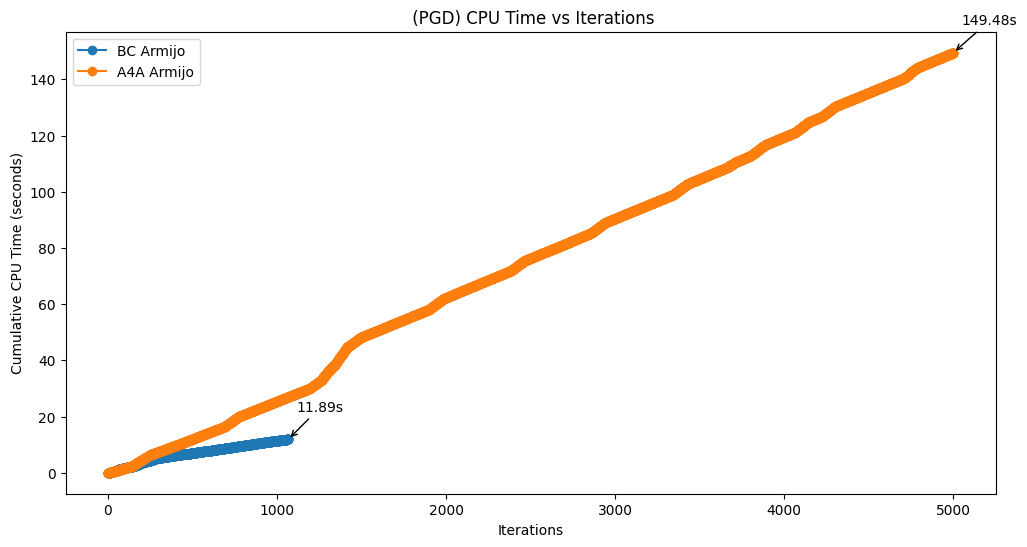

In [ ]:
plot_cpu_time(
    histories=[history_bc_armijo, history_a4a_armijo],
    labels=["BC Armijo", "A4A Armijo"],
    title=" (PGD) CPU Time vs Iterations"
)


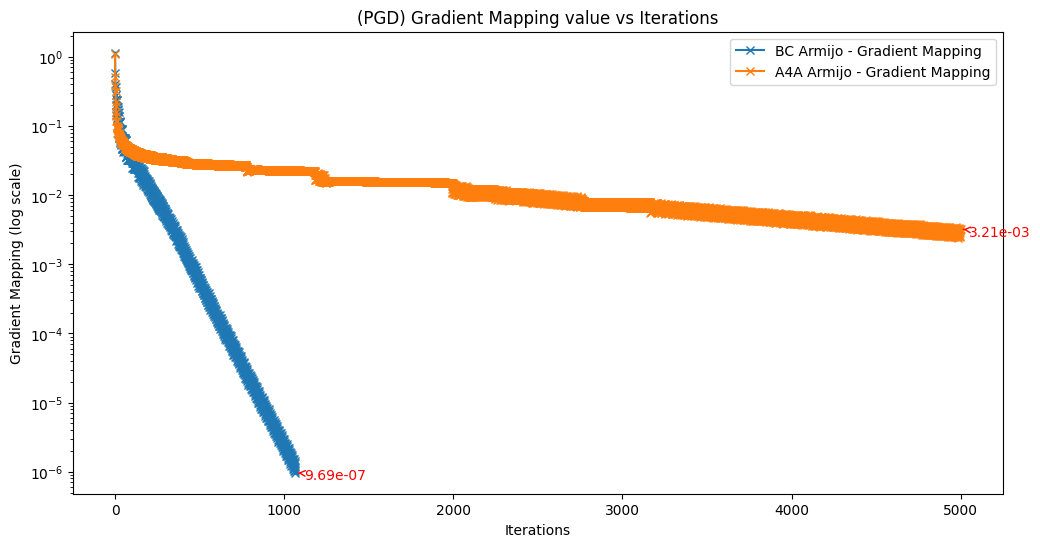

In [ ]:
import matplotlib.pyplot as plt

def gradient_mapping_plot(histories, labels, title="Gradient Mapping vs Iterations"):
    if len(histories) != len(labels):
        raise ValueError("The number of histories must match the number of labels.")

    plt.figure(figsize=(12, 6))

    for history, label in zip(histories, labels):
        # Check if the necessary keys exist
        if "iteration" not in history or "gradient_mapping" not in history:
            print(f"Skipping history for {label} due to missing keys.")
            continue

        iterations = history["iteration"]
        gradient_mapping = history["gradient_mapping"]

        # Check if lengths match, and trim the arrays to match the smaller length
        min_length = min(len(iterations), len(gradient_mapping))
        iterations = iterations[:min_length]
        gradient_mapping = gradient_mapping[:min_length]

        # Plot the gradient mapping
        plt.plot(iterations, gradient_mapping, label=f'{label} - Gradient Mapping', marker='x')

        # Calculate and annotate the final gradient mapping value
        final_gradient = gradient_mapping[-1]  # The last value of gradient mapping
        plt.annotate(f"{final_gradient:.2e}",
                     xy=(iterations[-1], final_gradient),
                     xytext=(iterations[-1] + 50, final_gradient * 0.8),
                     arrowprops=dict(arrowstyle="->", color="red"),
                     fontsize=10, color="red")

    plt.xlabel("Iterations")
    plt.ylabel("Gradient Mapping (log scale)")
    plt.title(title)
    plt.legend()

    # Set the y-axis to log scale
    plt.yscale('log')

    # Show the plot
    plt.show()

gradient_mapping_plot(
    histories=[history_bc_armijo, history_a4a_armijo],
    labels=["BC Armijo", "A4A Armijo"],
    title="(PGD) Gradient Mapping value vs Iterations"
)


In [ ]:
import prettytable

def pgd_training_summary():
    # Extracting final values from training history for Breast Cancer dataset
    final_objective_bc = history_bc_armijo["objective_value"][-1]
    final_gradient_mapping_bc = history_bc_armijo["gradient_mapping"][-1]
    final_accuracy_bc = test_accuracy_bc
    total_time_bc = total_training_time_bc

    # Extracting final values from training history for A4A dataset
    final_objective_a4a = history_a4a_armijo["objective_value"][-1]
    final_gradient_mapping_a4a = history_a4a_armijo["gradient_mapping"][-1]
    final_accuracy_a4a = test_accuracy_a4a
    total_time_a4a = total_training_time_a4a

    # Creating a pretty table
    table = prettytable.PrettyTable()
    table.field_names = ["Dataset", "Final Objective Value", "Final Gradient Mapping", "Accuracy (%)", "Total Training Time (s)"]

    # Adding rows to the table
    table.add_row(["Breast Cancer", f"{final_objective_bc:.2e}", f"{final_gradient_mapping_bc:.2e}", f"{final_accuracy_bc*100:.2f}", f"{total_time_bc:.2f}"])
    table.add_row(["A4A", f"{final_objective_a4a:.2e}", f"{final_gradient_mapping_a4a:.2e}", f"{final_accuracy_a4a*100:.2f}", f"{total_time_a4a:.2f}"])

    # Print the title first
    print("----------------------------------------Projected Gradient Descent----------------------------------------")

    # Print the table
    print(table)

# Call the function to print the summary
pgd_training_summary()


----------------------------------------Projected Gradient Descent----------------------------------------
+---------------+-----------------------+------------------------+--------------+-------------------------+
|    Dataset    | Final Objective Value | Final Gradient Mapping | Accuracy (%) | Total Training Time (s) |
+---------------+-----------------------+------------------------+--------------+-------------------------+
| Breast Cancer |        6.97e-02       |        9.69e-07        |    94.74     |          11.89          |
|      A4A      |        2.33e-03       |        3.21e-03        |    83.36     |          149.50         |
+---------------+-----------------------+------------------------+--------------+-------------------------+


# Comparative Summary

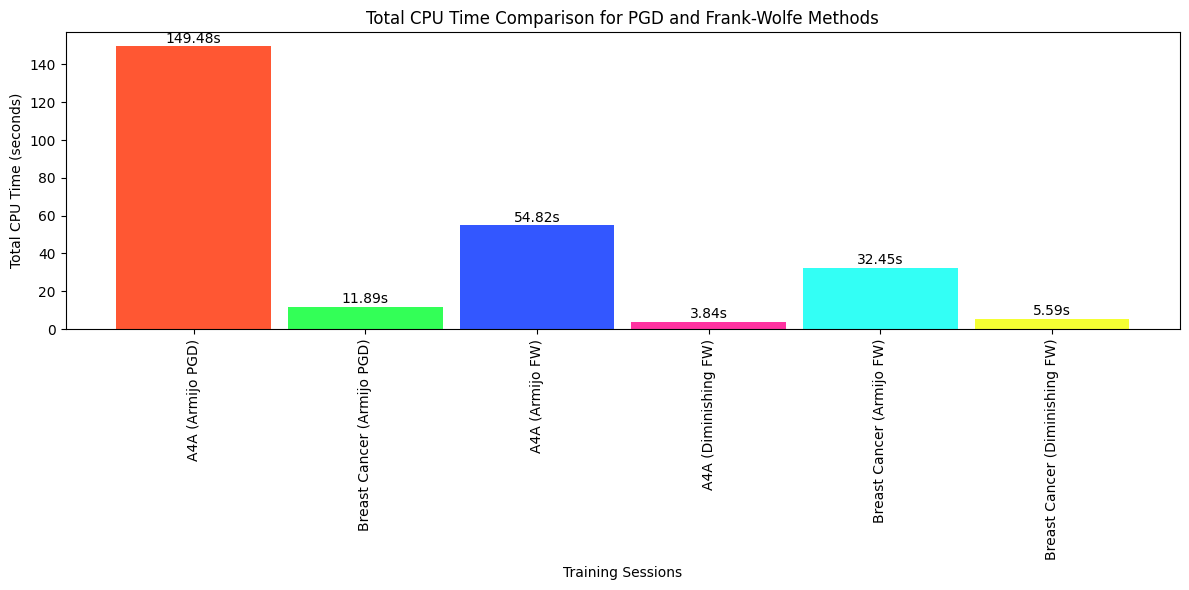

In [ ]:
import matplotlib.pyplot as plt

def cpu_times_bar(histories, labels, title="Total CPU Time for PGD and Frank-Wolfe Methods"):
    """
    Plots the total CPU time for each training session (PGD and Frank-Wolfe methods) in a bar plot.

    Args:
        histories (list of dict): A list of dictionaries, each containing a training history.
                                  Each dictionary should include 'cpu_time' keys.
        labels (list of str): A list of labels for the corresponding histories.
        title (str): Title of the plot.
    """
    if len(histories) != len(labels):
        raise ValueError("The number of histories must match the number of labels.")

    # List to store the total CPU times
    total_times = []

    # Loop through each history and extract the total training time
    for history in histories:
        if "cpu_time" not in history:
            print(f"Skipping history due to missing 'cpu_time' key.")
            continue
        # The last value in 'cpu_time' is the total training time
        total_times.append(history["cpu_time"][-1])

    # Create a bar plot for the total CPU times
    plt.figure(figsize=(12, 6))

    # Define a new set of vibrant colors
    bar_colors = ['#FF5733', '#33FF57', '#3357FF', '#FF33A1', '#33FFF5', '#F5FF33']

    # Create bars with reduced width to remove space between bars
    bar_width = 0.9  # Increase width to remove space
    plt.bar(labels, total_times, color=bar_colors, width=bar_width)

    # Annotate each bar with its total time
    for i, total_time in enumerate(total_times):
        plt.text(i, total_time + 2, f"{total_time:.2f}s", ha='center', fontsize=10)

    plt.xlabel("Training Sessions")
    plt.ylabel("Total CPU Time (seconds)")
    plt.title(title)

    # Rotate the x-axis labels vertically
    plt.xticks(rotation=90, ha="center")

    plt.tight_layout()
    plt.show()

# Extract CPU times for PGD models (for A4A and BC datasets)
cpu_times_a4a_armijo_pgd = history_a4a_armijo["cpu_time"]
cpu_times_bc_armijo_pgd = history_bc_armijo["cpu_time"]

# Extract CPU times for Frank-Wolfe models (for A4A and BC datasets)
cpu_a4a_armijo_fw = fw_model_a4a_armijo.history["cpu_time"]
cpu_a4a_diminishing_fw = fw_model_a4a_diminishing.history["cpu_time"]
cpu_bc_armijo_fw = fw_model_bc_armijo.history["cpu_time"]
cpu_bc_diminishing_fw = fw_model_bc_diminishing.history["cpu_time"]

# Now call the function with histories and labels for all 8 training sessions
cpu_times_bar(
    histories=[
        {"cpu_time": cpu_times_a4a_armijo_pgd},
        {"cpu_time": cpu_times_bc_armijo_pgd},
        {"cpu_time": cpu_a4a_armijo_fw},
        {"cpu_time": cpu_a4a_diminishing_fw},
        {"cpu_time": cpu_bc_armijo_fw},
        {"cpu_time": cpu_bc_diminishing_fw}
    ],
    labels=[
        "A4A (Armijo PGD)",
        "Breast Cancer (Armijo PGD)",
        "A4A (Armijo FW)",
        "A4A (Diminishing FW)",
        "Breast Cancer (Armijo FW)",
        "Breast Cancer (Diminishing FW)"
    ],
    title="Total CPU Time Comparison for PGD and Frank-Wolfe Methods"
)


**Tabular representation**

In [ ]:
def combined_training_summary():
    # Combined Table
    combined_table = prettytable.PrettyTable()
    combined_table.field_names = [
        "Model Name", "Dataset", "Line Search",
        "Final Objective Value", "Accuracy (%)",
        "Total CPU Time (s)"
    ]

    # Helper function to format all values in scientific notation
    def format_objective(value):
        return f"{value:.2e}"

    # Add PGD rows
    combined_table.add_row([
        "PGD", "Breast Cancer", "Armijo",
        format_objective(history_bc_armijo["objective_value"][-1]),
        f"{test_accuracy_bc * 100:.2f}",
        f"{total_training_time_bc:.2f}"
    ])
    combined_table.add_row([
        "PGD", "A4A", "Armijo",
        format_objective(history_a4a_armijo["objective_value"][-1]),
        f"{test_accuracy_a4a * 100:.2f}",
        f"{total_training_time_a4a:.2f}"
    ])

    # Add FW rows
    combined_table.add_row([
        "FW", "A4A", "Armijo",
        format_objective(fw_model_a4a_armijo.history["objective_value"][-1]),
        f"{accuracy_fw_a4a_armijo * 100:.2f}",
        round(fw_model_a4a_armijo.history["cpu_time"][-1], 2)
    ])
    combined_table.add_row([
        "FW", "A4A", "Diminishing",
        format_objective(fw_model_a4a_diminishing.history["objective_value"][-1]),
        f"{accuracy_fw_a4a_dim * 100:.2f}",
        round(fw_model_a4a_diminishing.history["cpu_time"][-1], 2)
    ])
    combined_table.add_row([
        "FW", "Breast Cancer", "Armijo",
        format_objective(fw_model_bc_armijo.history["objective_value"][-1]),
        f"{accuracy_fw_bc_armijo * 100:.2f}",
        round(fw_model_bc_armijo.history["cpu_time"][-1], 2)
    ])
    combined_table.add_row([
        "FW", "Breast Cancer", "Diminishing",
        format_objective(fw_model_bc_diminishing.history["objective_value"][-1]),
        f"{accuracy_fw_bc_dim * 100:.2f}",
        round(fw_model_bc_diminishing.history["cpu_time"][-1], 2)
    ])

    # Print the title and the combined table
    print("-------------------------------------------Training Results---------------------------------------------")
    print(combined_table)

# Call the function
combined_training_summary()


-------------------------------------------Training Results---------------------------------------------
+------------+---------------+-------------+-----------------------+--------------+--------------------+
| Model Name |    Dataset    | Line Search | Final Objective Value | Accuracy (%) | Total CPU Time (s) |
+------------+---------------+-------------+-----------------------+--------------+--------------------+
|    PGD     | Breast Cancer |    Armijo   |        6.97e-02       |    94.74     |       11.89        |
|    PGD     |      A4A      |    Armijo   |        2.33e-03       |    83.36     |       149.50       |
|     FW     |      A4A      |    Armijo   |        7.17e-03       |    85.45     |       54.82        |
|     FW     |      A4A      | Diminishing |        7.44e-03       |    82.11     |        3.84        |
|     FW     | Breast Cancer |    Armijo   |        2.27e-02       |    95.32     |       32.45        |
|     FW     | Breast Cancer | Diminishing |        2.2

# Some additional Plots

In [ ]:
def plot_duality_gap_vs_cpu_time(optimizer):
    """
    Plot the duality gap vs CPU time from the optimizer's history.

    Parameters:
    - optimizer: An instance of FrankWolfeOptimizer with fitted data.
    """
    # Ensure the optimizer has history data
    if optimizer.history is None:
        raise ValueError("Optimizer has not been fitted. Please fit the model first.")

    # Extract duality gaps and CPU times from the history
    duality_gaps = optimizer.history["dual_gap"]
    cpu_times = optimizer.history["cpu_time"]

    # Ensure both lists are of the same length by trimming the last entry of cpu_times
    if len(cpu_times) > len(duality_gaps):
        cpu_times = cpu_times[:-1]

    # Plotting the duality gap vs CPU time
    plt.figure(figsize=(8, 6))
    plt.plot(cpu_times, duality_gaps, marker='o', linestyle='-', color='red')
    plt.yscale('log')  # Log scale for better visibility of duality gap
    plt.xlabel('CPU Time (seconds)')
    plt.ylabel('Duality Gap (Log Scale)')
    plt.title('Duality Gap vs CPU Time during Frank-Wolfe Optimization')
    plt.show()


In [ ]:
def plot_duality_gap_vs_cpu_time(optimizer1, optimizer2, dataset_name="Dataset", label1="Optimizer 1", label2="Optimizer 2"):
    """
    Plot the duality gap vs CPU time from two optimizers' history on the same plot, for a single dataset.

    Parameters:
    - optimizer1: An instance of FrankWolfeOptimizer with fitted data (first optimizer).
    - optimizer2: An instance of FrankWolfeOptimizer with fitted data (second optimizer).
    - dataset_name: Name of the dataset used with both optimizers (for the plot label).
    - label1: Label for the first optimizer in the plot legend.
    - label2: Label for the second optimizer in the plot legend.
    """
    # Ensure both optimizers have history data
    if optimizer1.history is None or optimizer2.history is None:
        raise ValueError("Both optimizers must be fitted before plotting.")

    # Extract duality gaps and CPU times for both optimizers
    duality_gaps1 = optimizer1.history["dual_gap"]
    cpu_times1 = optimizer1.history["cpu_time"]

    duality_gaps2 = optimizer2.history["dual_gap"]
    cpu_times2 = optimizer2.history["cpu_time"]

    # Ensure both lists are of the same length by trimming the last entry of cpu_times if necessary
    if len(cpu_times1) > len(duality_gaps1):
        cpu_times1 = cpu_times1[:-1]
    if len(cpu_times2) > len(duality_gaps2):
        cpu_times2 = cpu_times2[:-1]

    # Plotting the duality gap vs CPU time for both optimizers with dataset name
    plt.figure(figsize=(8, 6))
    plt.plot(cpu_times1, duality_gaps1, marker='o', linestyle='-', color='orange', label=f'{label1} - {dataset_name}')
    plt.plot(cpu_times2, duality_gaps2, marker='x', linestyle='--', color='blue', label=f'{label2} - {dataset_name}')

    plt.yscale('log')  # Log scale for better visibility of duality gap
    plt.xlabel('CPU Time (seconds)')
    plt.ylabel('Duality Gap (Log Scale)')
    plt.title(f'Duality Gap vs CPU Time for {dataset_name}')
    plt.legend()
    plt.show()


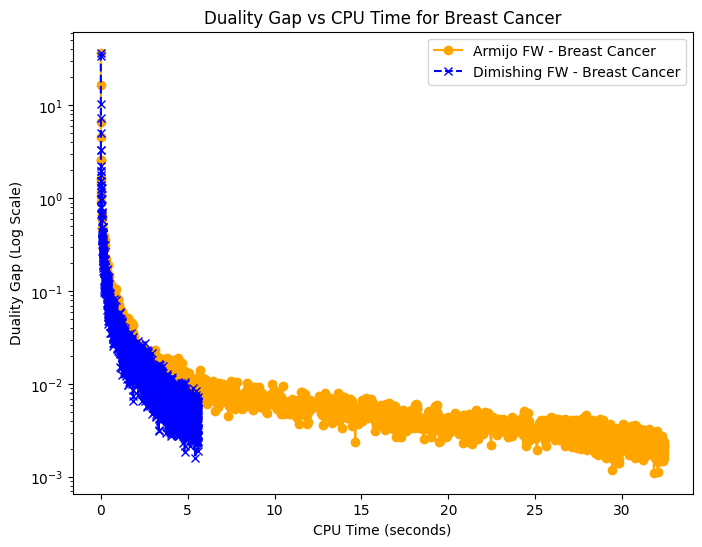

In [ ]:
plot_duality_gap_vs_cpu_time(fw_model_bc_armijo, fw_model_bc_diminishing,
                                            dataset_name="Breast Cancer",
                                            label2="Dimishing FW", label1="Armijo FW")


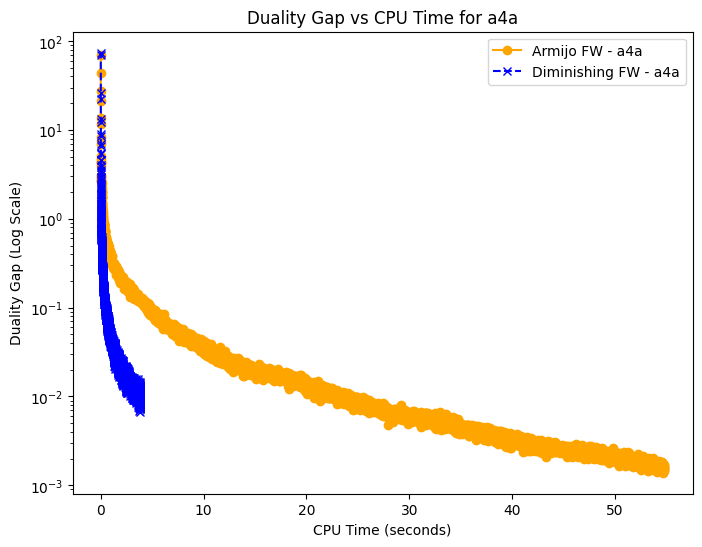

In [ ]:
plot_duality_gap_vs_cpu_time(fw_model_a4a_armijo, fw_model_a4a_diminishing,
                                            dataset_name="a4a",
                                            label1="Armijo FW", label2="Diminishing FW")